# Level Truncation in String Field Theory

H. Erbin, R. Finotello, M. Kudrna

## Minimal Models

We consider minimal models in String Field Theory and their truncation levels.
We use machine learning techniques to extrapolate the value of the truncations $L$ at $\infty$ given the results using fits of polynomials in $\frac{1}{L}$.

## Exploratory Data Analysis

In this notebook we perform an exploratory data analysis to better understand what kind of features can achieve the best possible performance.
We use the [**tidy dataset**](./minimal-models_tidy.ipynb) created previously.

In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
import shap
import re
import tqdm
import glob

from lightgbm import LGBMRegressor

In [2]:
sns.set()
ratio   = lambda x, y: (6 * y, 5 * x)

os.makedirs('./img', exist_ok=True)

In [3]:
def savefig(filename, fig, show=False):
    '''
    Save a Matplotlib figure to file.
    
    Needed arguments:
        filename: the path to the saved file in the img directory (no extension),
        fig:      the Matplotlib figure object.
        
    Optional arguments:
        show: show the plot inline (bool).
    '''
    
    # save the figure to file (PDF and PNG)
    fig.tight_layout()
    fig.savefig(os.path.join('./img', filename + '.pdf'), dpi=144, format='pdf')
    fig.savefig(os.path.join('./img', filename + '.png'), dpi=144, format='png')
    
    # show if interactive
    if show:
        plt.show()
    
    # release memory
    fig.clf()
    plt.close(fig)

In [4]:
def mosaic(wpath, cols, ratio=1):
    '''
    Display a mosaic of images given a wildcard path and a number of columns.
    
    Needed arguments:
        wpath: the path with wildcards (e.g. img/*.png),
        cols:  the number of columns of the arrangement (int).
        
    Optional arguments:
        ratio: width/height ratio with respect to (6, 5) (float).
    '''
    
    # retrieve the path
    path = glob.glob(wpath)
    img  = [mimg.imread(img) for img in path]
    
    # create figure
    fig = plt.figure(figsize=(6 * ratio, 5 * ratio))
    
    # iterate over images and display them without axes
    for n in tqdm.trange(len(img)):
        plt.subplot(int(len(img) / cols) + 1, int(cols), n + 1)
        plt.axis('off')
        plt.imshow(img[n])
    
    fig.tight_layout()
    plt.show()
    fig.clf()
    plt.close(fig)    

## Load the Dataset

The dataset contains the tidy data in JSON format (data is in *records* orientation, that is `[{column -> value} ... {column -> value}]`).

In [5]:
df = pd.read_json('./data/data_tidy.json.gz', orient='records')

df_nrows, df_ncols = df.shape

print(f'Shape of the dataset: {df_nrows:d} rows, {df_ncols:d} columns.')

Shape of the dataset: 802 rows, 34 columns.


In [6]:
df.filter(regex='weight|type').describe()

,weight,type
count,802.000000,802.000000
mean,0.863611,0.837905
std,1.260902,0.368768
min,-0.428571,0.000000
25%,0.000000,1.000000
50%,0.375000,1.000000
75%,1.400000,1.000000
max,5.000000,1.000000


In [7]:
df.filter(regex='lev_0').describe()

,lev_02_im,lev_02_re,lev_03_im,lev_03_re,lev_04_im,lev_04_re,lev_05_im,lev_05_re,lev_06_im,lev_06_re,lev_07_im,lev_07_re,lev_08_re,lev_09_re
count,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000
mean,-0.002978,0.045633,-0.002978,0.009675,-0.000898,0.595157,-0.000898,0.715941,-0.000194,-1.126024,-0.000194,-1.332449,3.309029,3.750002
std,0.121900,2.163629,0.121900,2.707188,0.028938,7.934509,0.028938,8.783797,0.004319,20.653008,0.004319,21.829680,52.236572,54.365876
min,-2.365767,-16.510461,-2.365767,-19.052532,-0.551706,-67.734861,-0.551706,-73.752143,-0.116019,-153.591878,-0.116019,-158.215607,-375.159011,-398.506858
25%,0.000000,-0.350257,0.000000,-0.400511,0.000000,-0.319542,0.000000,-0.227475,0.000000,-0.291969,0.000000,-0.369628,-0.324810,-0.235071
50%,0.000000,0.170219,0.000000,0.252703,0.000000,0.258065,0.000000,0.272421,0.000000,0.262414,0.000000,0.271859,0.252886,0.277450
75%,0.000000,0.745508,0.000000,0.823703,0.000000,0.803563,0.000000,0.801278,0.000000,0.750997,0.000000,0.819057,0.813531,0.801332
max,1.881604,14.298479,1.881604,19.543429,0.367557,78.213480,0.367557,86.527048,0.002778,131.696151,0.002778,138.859050,401.749230,411.917281


In [8]:
df.filter(regex='lev_1').describe()

,lev_10_re,lev_11_re,lev_12_re,lev_13_re,lev_14_re,lev_15_re,lev_16_re,lev_17_re,lev_18_re,lev_19_re
count,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000
mean,-6.265882,-7.153977,12.498858,14.240734,-20.662335,-23.768895,32.637757,-0.024078,0.107420,0.079206
std,135.310180,140.027968,350.186144,360.787234,854.323813,877.619226,1932.039809,1.379174,1.525578,1.541414
min,-1019.836200,-1056.973997,-3088.571225,-3202.704999,-7214.470476,-7360.544373,-19507.330644,-34.635396,-1.942494,-1.978425
25%,-0.289074,-0.326094,-0.280155,-0.227064,-0.282620,-0.365783,-0.280705,0.000000,0.000000,0.000000
50%,0.290469,0.288858,0.266248,0.292627,0.290582,0.277707,0.274303,0.000000,0.000000,0.000000
75%,0.791410,0.818470,0.824135,0.824630,0.816817,0.793526,0.822847,0.000000,0.000000,0.000000
max,1080.829182,1132.462512,2770.517946,2858.492005,8134.783092,8380.547417,17641.456613,1.919934,39.777294,40.384520


In [9]:
df.filter(regex='lev_2').describe()

,lev_20_re,lev_21_re,lev_22_re,lev_23_re,lev_24_re
count,802.000000,802.000000,802.000000,802.000000,802.000000
mean,-0.054189,0.008803,0.008784,0.004894,0.004851
std,1.588175,0.129718,0.129713,0.081461,0.081244
min,-42.287805,-0.891060,-0.893784,-0.617806,-0.618627
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.915668,1.915668,1.914823,1.431241,1.430779


## Analysis

We then take a look in depth to the dataset and visualise some of the results.

In [10]:
# print max and min values of the truncation levels
max_val    = df.filter(regex='lev_').max().max()
min_val    = df.filter(regex='lev_').min().min()

print(f'Range of values of the truncation levels: [{min_val:.3f}, {max_val:.3f}].')

Range of values of the truncation levels: [-19507.331, 17641.457].


Grouping by `type` we can show several properties of the data:

In [11]:
df_data      = df.filter(regex='weight|type|lev_').copy()
df_data_cols = df_data.columns

In [12]:
for n in tqdm.trange(len(df_data_cols)):
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=ratio(1,1))
    
    sns.histplot(df_data,
                 x=df_data_cols[n],
                 hue='type',
                 ax=ax
                )
    ax.set(title='',
           ylabel='count',
           xscale='log',
           yscale='log'
          )
    savefig(f'{df_data_cols[n]}_per_type', fig)

  0%|          | 0/31 [00:00<?, ?it/s]

  3%|▎         | 1/31 [00:00<00:13,  2.19it/s]

  6%|▋         | 2/31 [00:00<00:12,  2.35it/s]

 10%|▉         | 3/31 [00:01<00:11,  2.43it/s]

 13%|█▎        | 4/31 [00:01<00:12,  2.08it/s]

 16%|█▌        | 5/31 [00:02<00:11,  2.23it/s]

 19%|█▉        | 6/31 [00:02<00:13,  1.87it/s]

 23%|██▎       | 7/31 [00:03<00:11,  2.11it/s]

 26%|██▌       | 8/31 [00:05<00:19,  1.16it/s]

 29%|██▉       | 9/31 [00:05<00:16,  1.37it/s]

 32%|███▏      | 10/31 [00:07<00:23,  1.12s/it]

 35%|███▌      | 11/31 [00:07<00:17,  1.12it/s]

 39%|███▊      | 12/31 [00:11<00:30,  1.62s/it]

 42%|████▏     | 13/31 [00:11<00:22,  1.24s/it]

 45%|████▌     | 14/31 [00:14<00:30,  1.82s/it]

 48%|████▊     | 15/31 [00:22<00:58,  3.66s/it]

 52%|█████▏    | 16/31 [00:32<01:20,  5.39s/it]

 55%|█████▍    | 17/31 [00:55<02:30, 10.75s/it]

 58%|█████▊    | 18/31 [01:18<03:07, 14.42s/it]

 61%|██████▏   | 19/31 [02:21<05:47, 28.97s/it]

 65%|██████▍   | 20/31 [03:30<07:30, 40.97s/it]

 68%|██████▊   | 21/31 [06:14<12:58, 77.86s/it]

 71%|███████   | 22/31 [08:54<15:24, 102.74s/it]

 74%|███████▍  | 23/31 [15:31<25:27, 190.98s/it]

 77%|███████▋  | 24/31 [15:32<15:36, 133.79s/it]

 81%|████████  | 25/31 [15:32<09:22, 93.75s/it] 

 84%|████████▍ | 26/31 [15:32<05:28, 65.72s/it]

 87%|████████▋ | 27/31 [15:33<03:04, 46.10s/it]

 90%|█████████ | 28/31 [15:33<01:37, 32.37s/it]

 94%|█████████▎| 29/31 [15:33<00:45, 22.75s/it]

 97%|█████████▋| 30/31 [15:34<00:16, 16.02s/it]

100%|██████████| 31/31 [15:34<00:00, 11.31s/it]

100%|██████████| 31/31 [15:34<00:00, 30.14s/it]

  0%|          | 0/31 [00:00<?, ?it/s]

 29%|██▉       | 9/31 [00:00<00:00, 89.45it/s]

 58%|█████▊    | 18/31 [00:00<00:00, 89.28it/s]

 87%|████████▋ | 27/31 [00:00<00:00, 88.99it/s]

100%|██████████| 31/31 [00:00<00:00, 88.60it/s]

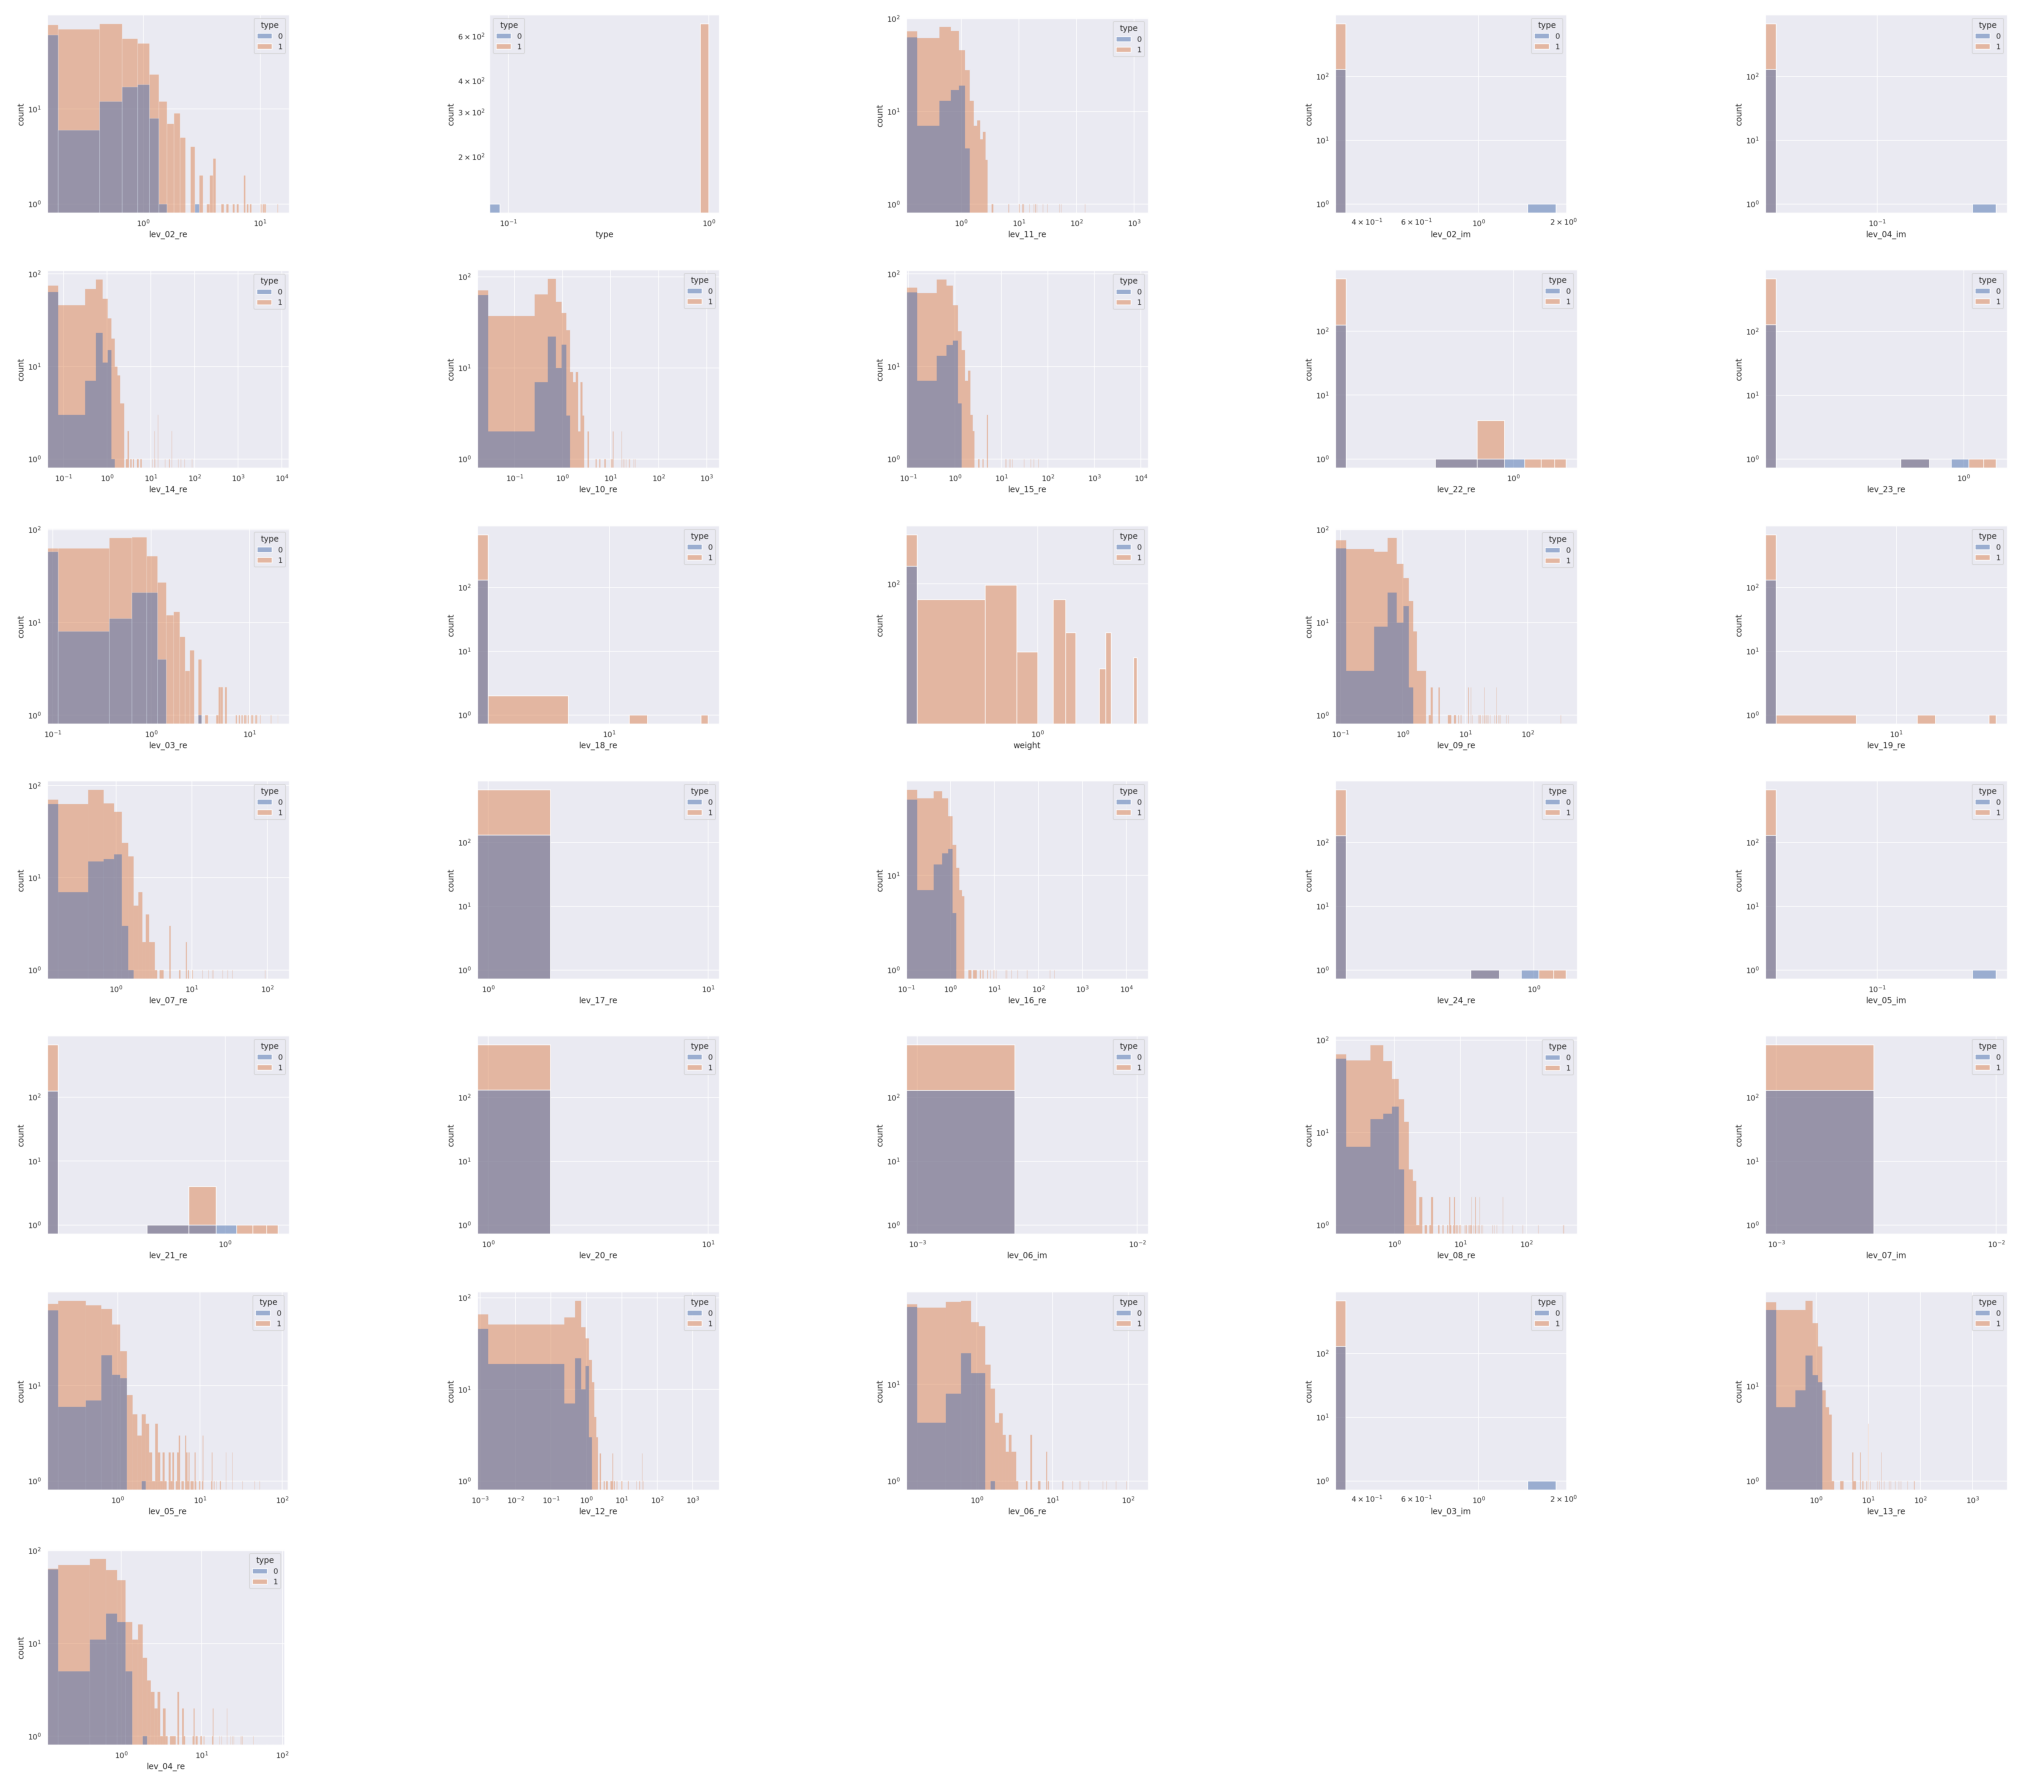

In [13]:
mosaic('./img/*_per_type.png', 5, 5)

In fact it seems that larger values are usually connected to `type`$ = 1$, while `type`$ = 0$ shows less dispersion.

We can operate in the same way for the `weight` variable by first finding discrete intervals and then studying the distribution of the the other variables in those intervals.

In [14]:
df_data['weight_bin'] = pd.cut(df['weight'], [int(df['weight'].min())-1, 0, 1.5, int(df['weight'].max())])

In [15]:
for n in tqdm.trange(len(df_data_cols)):
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=ratio(1,1))
    
    sns.histplot(df_data,
                 x=df_data_cols[n],
                 hue='weight_bin',
                 ax=ax
                )
    ax.set(title='',
           ylabel='count',
           xscale='log',
           yscale='log'
          )
    savefig(f'{df_data_cols[n]}_per_weight_bin', fig)

  0%|          | 0/31 [00:00<?, ?it/s]

  3%|▎         | 1/31 [00:00<00:10,  2.95it/s]

  6%|▋         | 2/31 [00:00<00:10,  2.83it/s]

 10%|▉         | 3/31 [00:01<00:10,  2.73it/s]

 13%|█▎        | 4/31 [00:01<00:12,  2.10it/s]

 16%|█▌        | 5/31 [00:02<00:11,  2.20it/s]

 19%|█▉        | 6/31 [00:03<00:14,  1.78it/s]

 23%|██▎       | 7/31 [00:03<00:12,  2.00it/s]

 26%|██▌       | 8/31 [00:05<00:23,  1.04s/it]

 29%|██▉       | 9/31 [00:06<00:18,  1.20it/s]

 32%|███▏      | 10/31 [00:08<00:29,  1.39s/it]

 35%|███▌      | 11/31 [00:09<00:21,  1.09s/it]

 39%|███▊      | 12/31 [00:13<00:40,  2.11s/it]

 42%|████▏     | 13/31 [00:14<00:28,  1.59s/it]

 45%|████▌     | 14/31 [00:18<00:40,  2.36s/it]

 48%|████▊     | 15/31 [00:29<01:18,  4.93s/it]

 52%|█████▏    | 16/31 [01:01<03:16, 13.07s/it]

 55%|█████▍    | 17/31 [01:35<04:33, 19.56s/it]

 58%|█████▊    | 18/31 [02:10<05:12, 24.01s/it]

 61%|██████▏   | 19/31 [03:42<08:53, 44.46s/it]

 65%|██████▍   | 20/31 [05:27<11:27, 62.53s/it]

 68%|██████▊   | 21/31 [09:32<19:33, 117.33s/it]

 71%|███████   | 22/31 [13:39<23:25, 156.19s/it]

 74%|███████▍  | 23/31 [23:33<38:21, 287.70s/it]

 77%|███████▋  | 24/31 [23:34<23:30, 201.50s/it]

 81%|████████  | 25/31 [23:34<14:06, 141.15s/it]

 84%|████████▍ | 26/31 [23:34<08:14, 98.91s/it] 

 87%|████████▋ | 27/31 [23:35<04:37, 69.35s/it]

 90%|█████████ | 28/31 [23:35<02:25, 48.65s/it]

 94%|█████████▎| 29/31 [23:35<01:08, 34.16s/it]

 97%|█████████▋| 30/31 [23:36<00:24, 24.01s/it]

100%|██████████| 31/31 [23:36<00:00, 16.91s/it]

100%|██████████| 31/31 [23:36<00:00, 45.70s/it]

  0%|          | 0/31 [00:00<?, ?it/s]

 29%|██▉       | 9/31 [00:00<00:00, 87.75it/s]

 58%|█████▊    | 18/31 [00:00<00:00, 87.77it/s]

 87%|████████▋ | 27/31 [00:00<00:00, 87.78it/s]

100%|██████████| 31/31 [00:00<00:00, 86.56it/s]

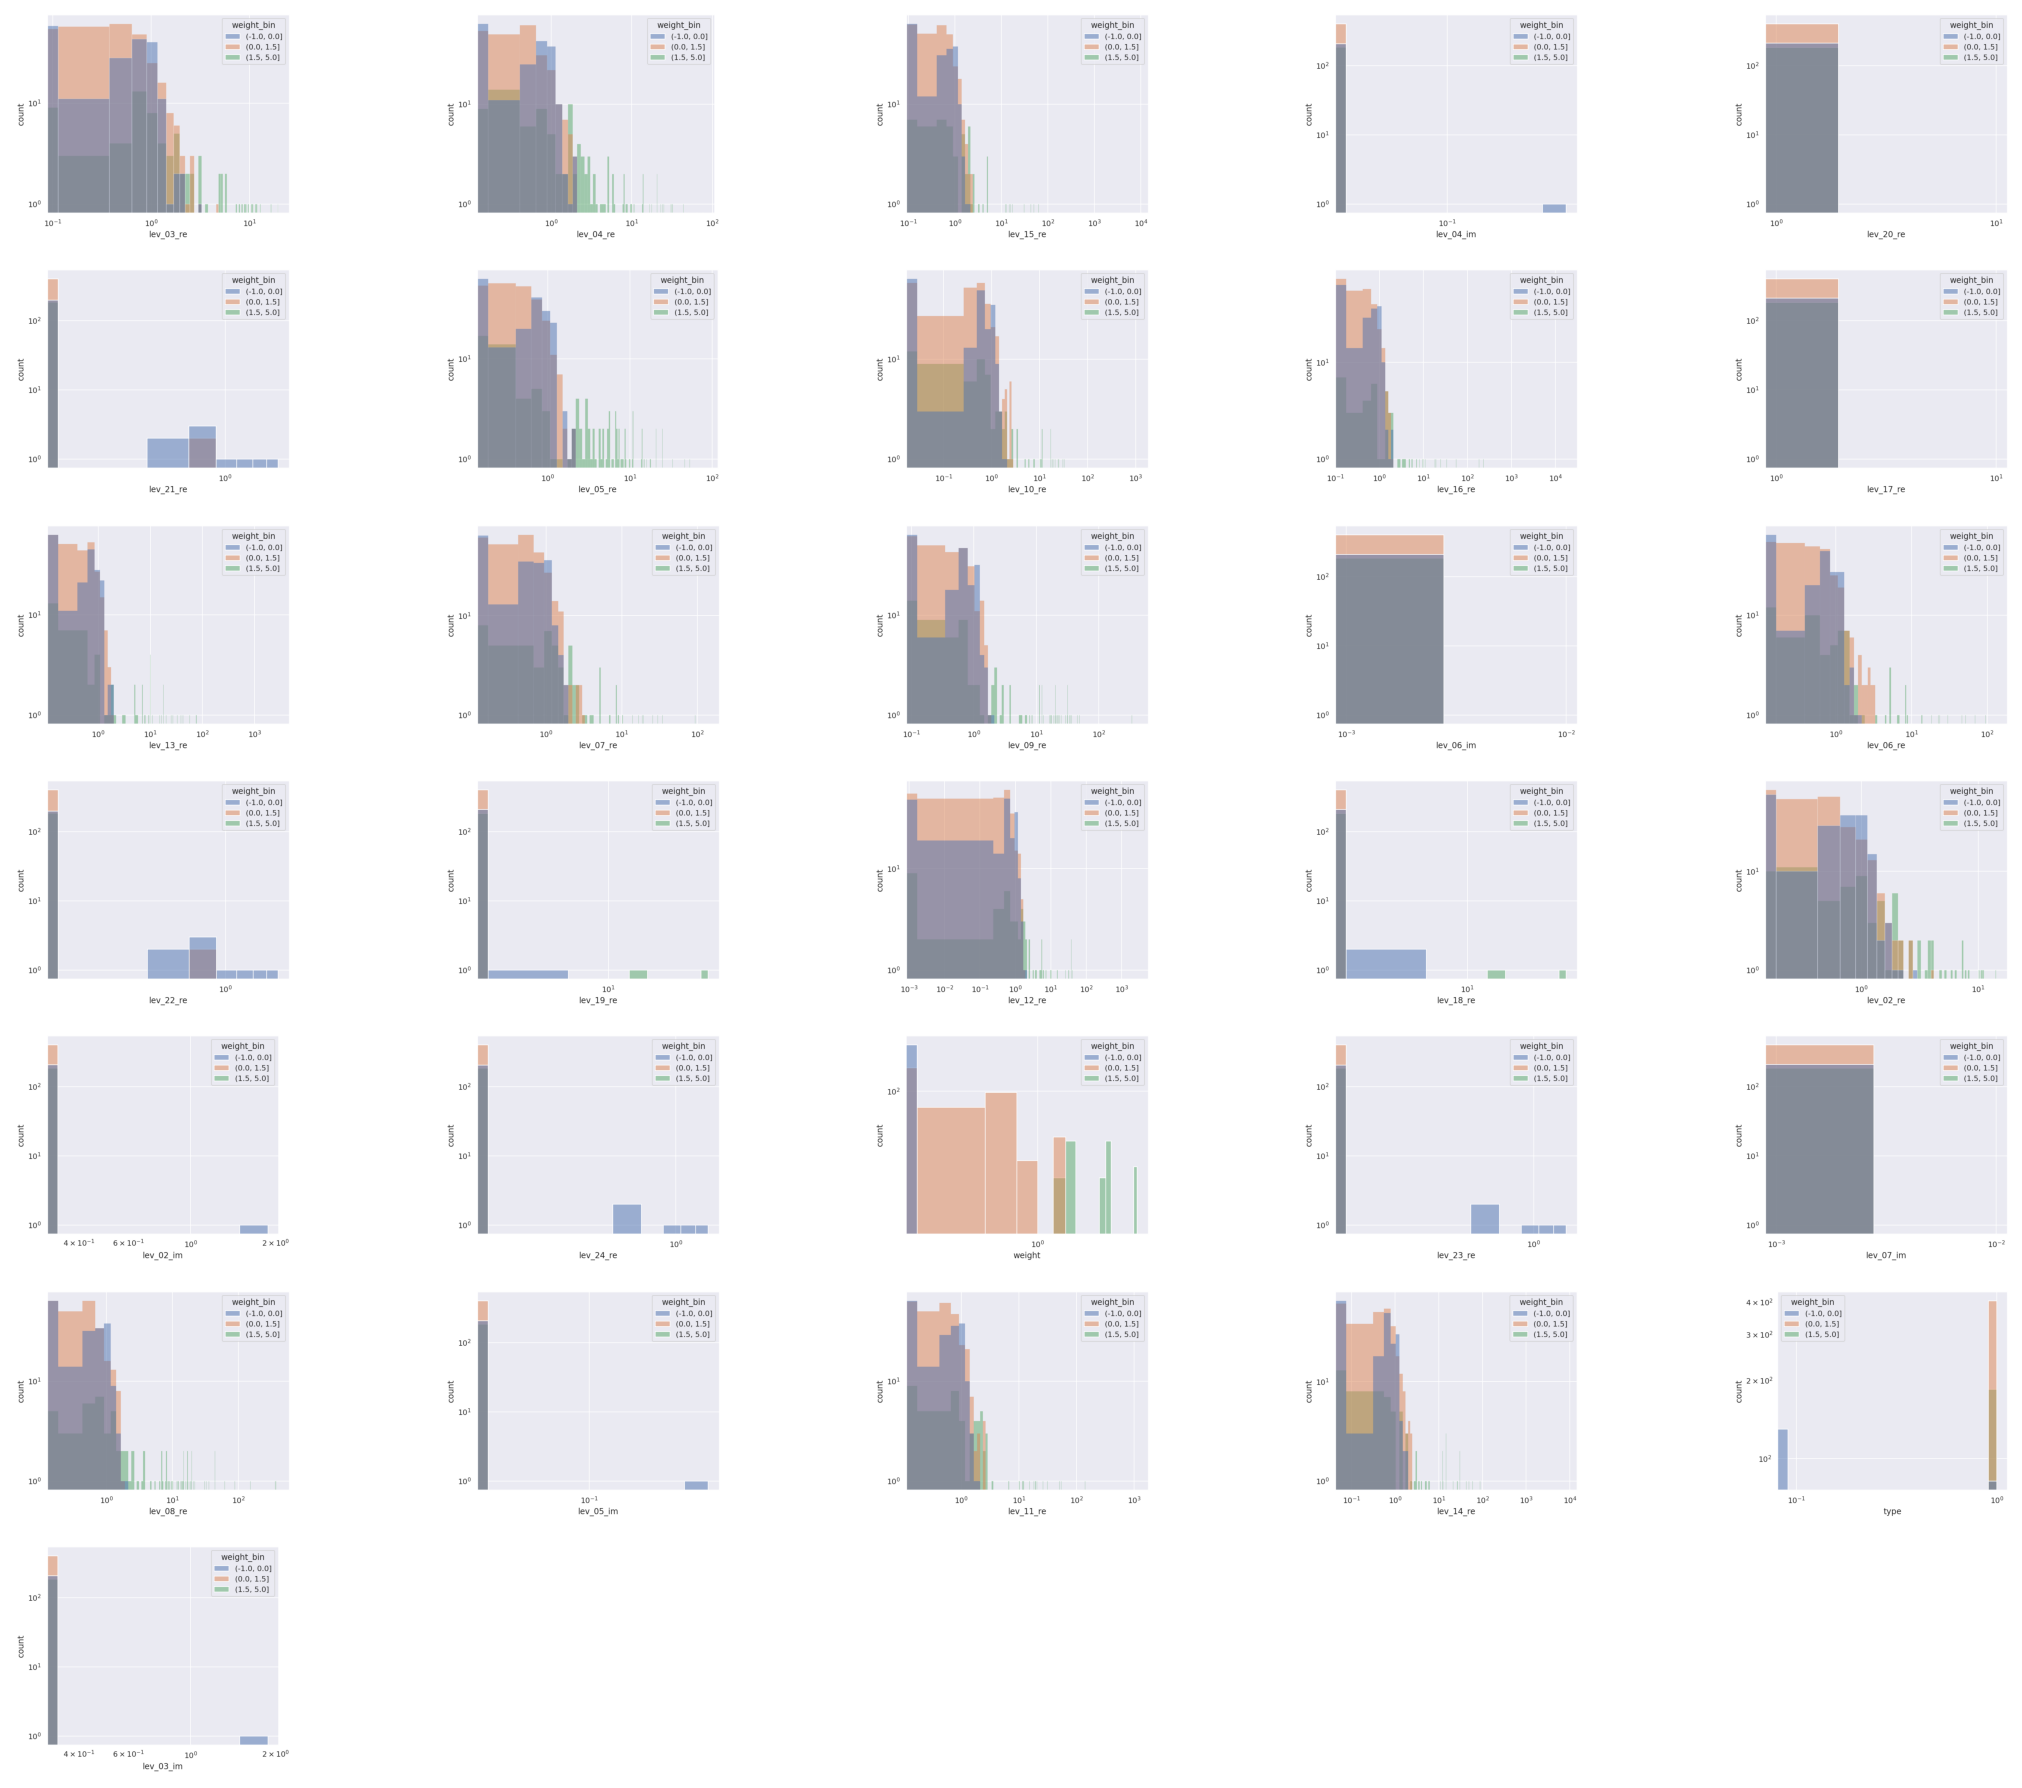

In [16]:
mosaic('./img/*_per_weight_bin.png', 5, 5)

We can also show the correlation and the covariance matrix of the data:

In [17]:
df_data     = df.filter(regex='weight|type|lev').copy()
covariance  = df_data.cov()
correlation = df_data.corr()

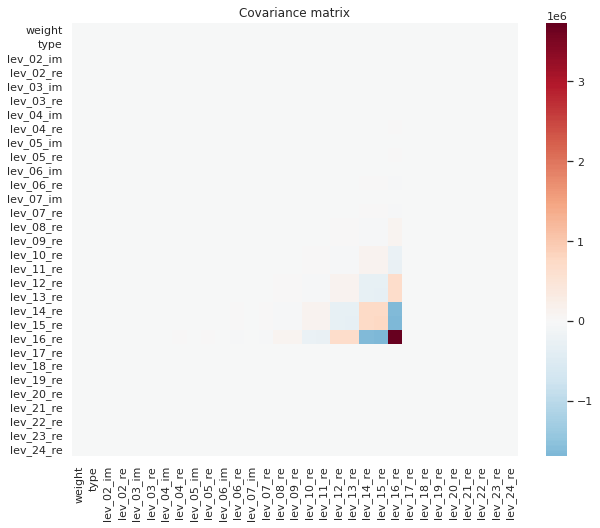

In [18]:
fig, ax = plt.subplots(1, 1, figsize=ratio(1.5,1.5))

sns.heatmap(covariance,
            center=0,
            cmap='RdBu_r',
            xticklabels=list(covariance.columns),
            yticklabels=list(covariance.index),
            ax=ax
           )
ax.set(title='Covariance matrix')

savefig('covariance', fig, show=True)

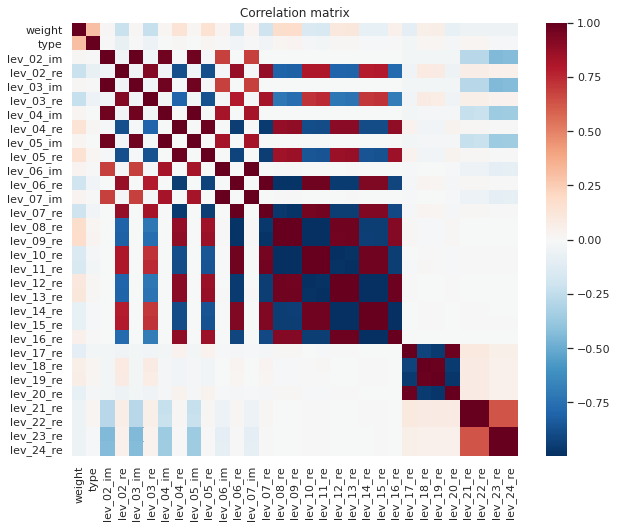

In [19]:
fig, ax = plt.subplots(1, 1, figsize=ratio(1.5,1.5))

sns.heatmap(correlation,
            center=0,
            cmap='RdBu_r',
            xticklabels=list(correlation.columns),
            yticklabels=list(correlation.index),
            ax=ax
           )
ax.set(title='Correlation matrix')

savefig('correlation', fig, show=True)

## Inverse Features

Before moving to the machine learning analysis we consider the truncation levels $L$ and add features $1 / L$ to the dataset and see their correlations with respect to the initial levels.

In [20]:
df_inv  = df.filter(regex='lev_').applymap(lambda x: 1 / x if x != 0 else 0).rename(columns=lambda x: re.sub('lev_', 'inv_lev_', x))
df_full = df.join(df_inv)

assert df_full.isna().sum().sum() == 0

In [21]:
# compute correlations
inv_correlation = df_full.filter(regex='weight|type|^inv_lev_').corr()

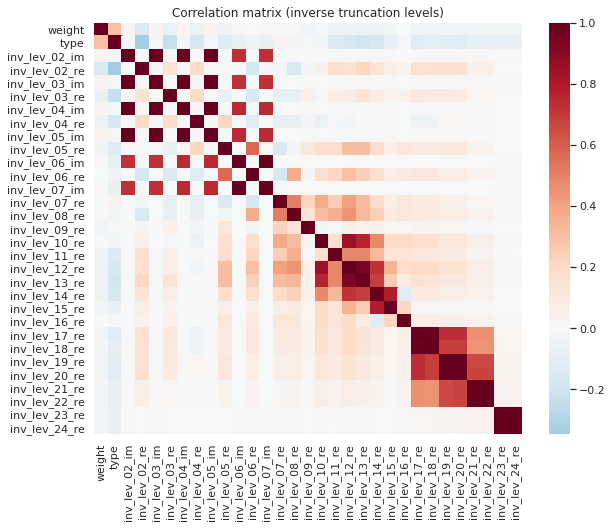

In [22]:
fig, ax = plt.subplots(1, 1, figsize=ratio(1.5,1.5))

sns.heatmap(inv_correlation,
            center=0,
            cmap='RdBu_r',
            xticklabels=list(inv_correlation.columns),
            yticklabels=list(inv_correlation.index),
            ax=ax
           )
ax.set(title='Correlation matrix (inverse truncation levels)')

savefig('inv_correlation', fig, show=True)

Truncation levels thus exhibit a milder, but more distributed, correlation which seems to suggest a convergence.
It may as well be more plausible that the inverse of the truncation levels might be more suitable to show convergence.

In [23]:
df_data_inv      = df_full.filter(regex='weight|type|^inv_lev_').copy()
df_data_cols_inv = df_data_inv.columns

In [24]:
for n in tqdm.trange(len(df_data_cols)):
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=ratio(1,1))
    
    sns.histplot(df_data_inv,
                 x=df_data_cols_inv[n],
                 hue='type',
                 ax=ax
                )
    ax.set(title='',
           ylabel='count',
           xscale='log',
           yscale='log'
          )
    savefig(f'{df_data_cols[n]}_per_type_inv', fig)

  0%|          | 0/31 [00:00<?, ?it/s]

  3%|▎         | 1/31 [00:00<00:09,  3.26it/s]

  6%|▋         | 2/31 [00:00<00:09,  3.11it/s]

 10%|▉         | 3/31 [00:01<00:09,  3.02it/s]

 13%|█▎        | 4/31 [00:02<00:21,  1.26it/s]

 16%|█▌        | 5/31 [00:03<00:17,  1.51it/s]

 19%|█▉        | 6/31 [00:25<02:56,  7.07s/it]

 23%|██▎       | 7/31 [00:25<02:01,  5.05s/it]

 26%|██▌       | 8/31 [02:16<14:06, 36.82s/it]

 29%|██▉       | 9/31 [02:16<09:29, 25.87s/it]

 32%|███▏      | 10/31 [02:48<09:38, 27.53s/it]

 35%|███▌      | 11/31 [02:48<06:27, 19.37s/it]

 39%|███▊      | 12/31 [04:01<11:14, 35.49s/it]

 42%|████▏     | 13/31 [04:02<07:29, 24.95s/it]

 45%|████▌     | 14/31 [06:38<18:16, 64.50s/it]

 48%|████▊     | 15/31 [08:14<19:41, 73.87s/it]

 52%|█████▏    | 16/31 [13:58<38:44, 154.94s/it]

 55%|█████▍    | 17/31 [15:24<31:18, 134.18s/it]

 58%|█████▊    | 18/31 [18:03<30:39, 141.53s/it]

 61%|██████▏   | 19/31 [19:06<23:37, 118.10s/it]

 65%|██████▍   | 20/31 [20:46<20:40, 112.74s/it]

 68%|██████▊   | 21/31 [25:19<26:47, 160.78s/it]

 71%|███████   | 22/31 [52:15<1:29:36, 597.39s/it]

 74%|███████▍  | 23/31 [1:01:20<1:17:33, 581.63s/it]

 77%|███████▋  | 24/31 [1:01:21<47:30, 407.25s/it]  

 81%|████████  | 25/31 [1:01:21<28:31, 285.20s/it]

 84%|████████▍ | 26/31 [1:01:21<16:38, 199.74s/it]

 87%|████████▋ | 27/31 [1:01:22<09:19, 139.91s/it]

 90%|█████████ | 28/31 [1:01:22<04:54, 98.04s/it] 

 94%|█████████▎| 29/31 [1:01:22<02:17, 68.73s/it]

 97%|█████████▋| 30/31 [1:01:23<00:48, 48.21s/it]

100%|██████████| 31/31 [1:01:23<00:00, 33.84s/it]

100%|██████████| 31/31 [1:01:23<00:00, 118.82s/it]

  0%|          | 0/31 [00:00<?, ?it/s]

 32%|███▏      | 10/31 [00:00<00:00, 91.22it/s]

 61%|██████▏   | 19/31 [00:00<00:00, 90.63it/s]

 90%|█████████ | 28/31 [00:00<00:00, 89.75it/s]

100%|██████████| 31/31 [00:00<00:00, 89.03it/s]

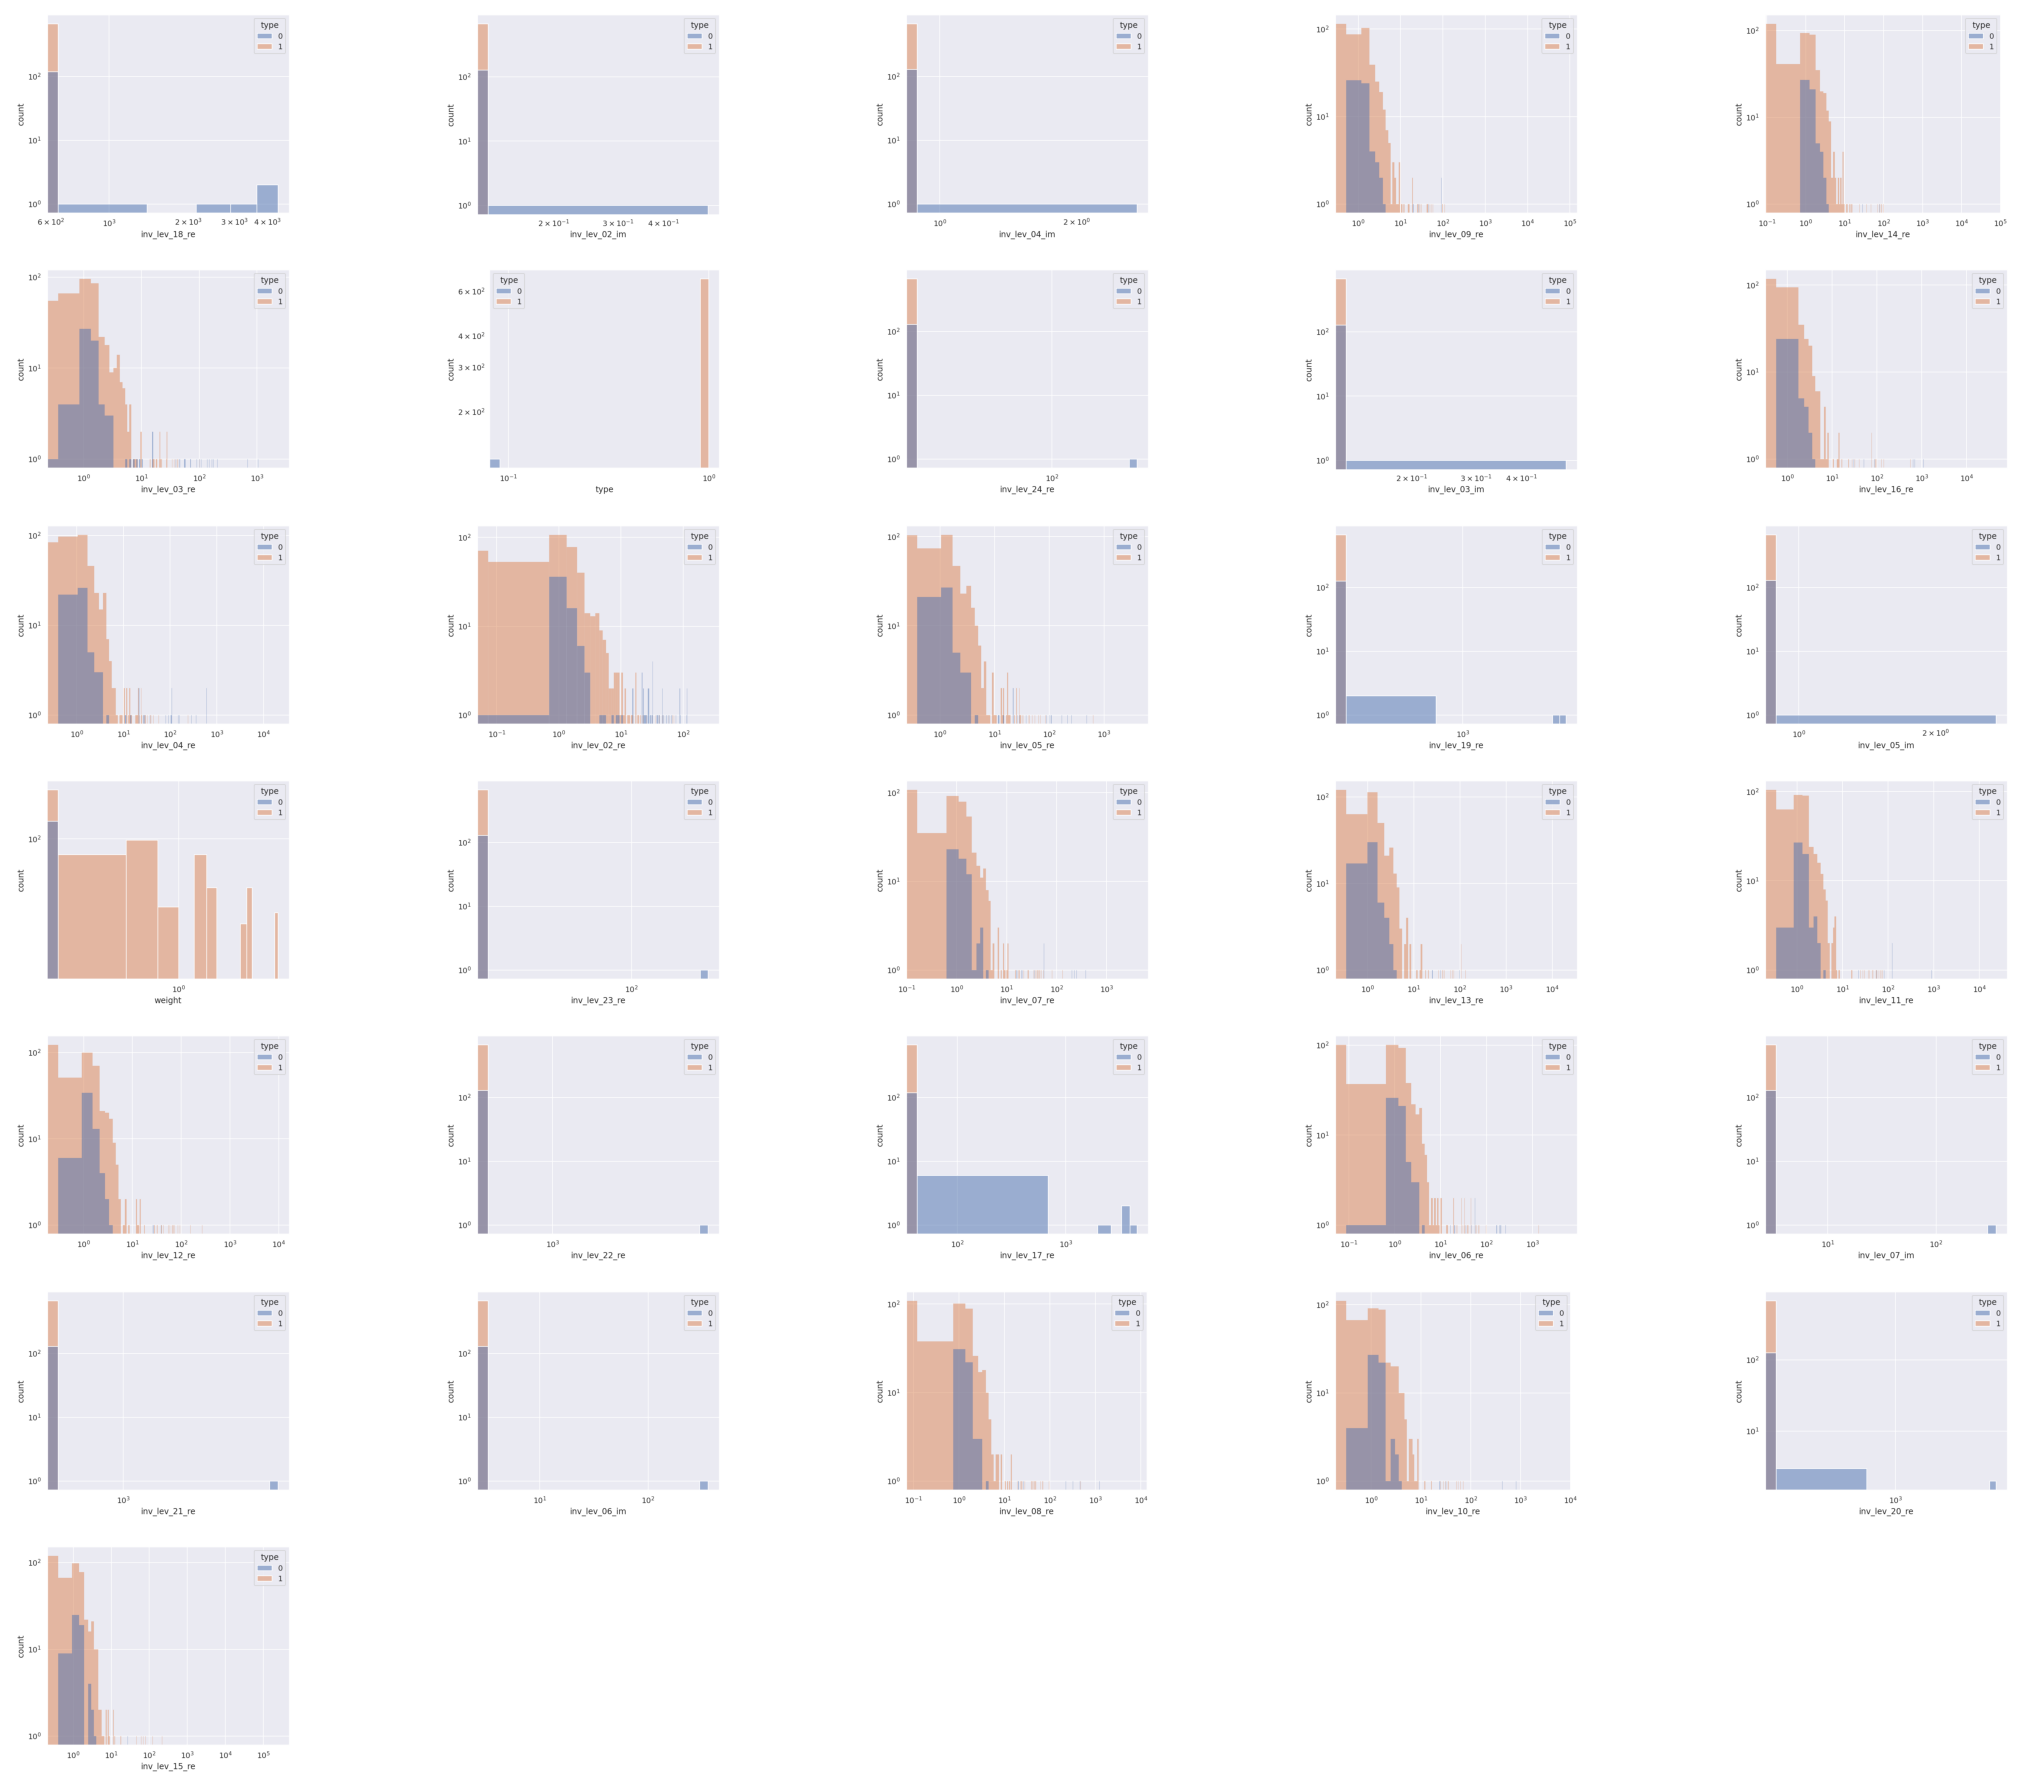

In [25]:
mosaic('./img/*_per_type_inv.png', 5, 5)

Differently from the case of the native features, the truncation levels seem to be more distributed between the two values of `type`.

In [26]:
df_data_inv['weight_bin'] = pd.cut(df_full['weight'], [int(df_full['weight'].min()) - 1, 0, 1.5, int(df_full['weight'].max())])

In [27]:
for n in tqdm.trange(len(df_data_cols)):
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=ratio(1,1))
    
    sns.histplot(df_data_inv,
                 x=df_data_cols_inv[n],
                 hue='weight_bin',
                 ax=ax
                )
    ax.set(title='',
           ylabel='count',
           xscale='log',
           yscale='log'
          )
    savefig(f'{df_data_cols[n]}_per_weight_bin_inv', fig)

  0%|          | 0/31 [00:00<?, ?it/s]

  3%|▎         | 1/31 [00:00<00:10,  2.88it/s]

  6%|▋         | 2/31 [00:00<00:10,  2.76it/s]

 10%|▉         | 3/31 [00:01<00:10,  2.71it/s]

 13%|█▎        | 4/31 [00:03<00:28,  1.05s/it]

 16%|█▌        | 5/31 [00:04<00:21,  1.18it/s]

 19%|█▉        | 6/31 [00:37<04:23, 10.53s/it]

 23%|██▎       | 7/31 [00:37<02:59,  7.48s/it]

 26%|██▌       | 8/31 [03:10<19:33, 51.03s/it]

 29%|██▉       | 9/31 [03:10<13:08, 35.83s/it]

 32%|███▏      | 10/31 [03:57<13:44, 39.27s/it]

 35%|███▌      | 11/31 [03:58<09:12, 27.60s/it]

 39%|███▊      | 12/31 [05:45<16:19, 51.56s/it]

 42%|████▏     | 13/31 [05:46<10:51, 36.21s/it]

 45%|████▌     | 14/31 [09:43<27:19, 96.45s/it]

 48%|████▊     | 15/31 [12:04<29:19, 109.98s/it]

 52%|█████▏    | 16/31 [20:33<57:25, 229.67s/it]

 55%|█████▍    | 17/31 [22:43<46:36, 199.72s/it]

 58%|█████▊    | 18/31 [26:43<45:53, 211.79s/it]

 61%|██████▏   | 19/31 [28:17<35:19, 176.59s/it]

 65%|██████▍   | 20/31 [30:45<30:48, 168.03s/it]

 68%|██████▊   | 21/31 [37:33<39:59, 239.97s/it]

 71%|███████   | 22/31 [1:17:40<2:13:29, 889.90s/it]

 74%|███████▍  | 23/31 [1:31:11<1:55:30, 866.33s/it]

 77%|███████▋  | 24/31 [1:31:11<1:10:45, 606.56s/it]

 81%|████████  | 25/31 [1:31:12<42:28, 424.72s/it]  

 84%|████████▍ | 26/31 [1:31:12<24:47, 297.42s/it]

 87%|████████▋ | 27/31 [1:31:13<13:53, 208.29s/it]

 90%|█████████ | 28/31 [1:31:13<07:17, 145.91s/it]

 94%|█████████▎| 29/31 [1:31:13<03:24, 102.25s/it]

 97%|█████████▋| 30/31 [1:31:14<01:11, 71.68s/it] 

100%|██████████| 31/31 [1:31:14<00:00, 50.28s/it]

100%|██████████| 31/31 [1:31:14<00:00, 176.60s/it]

  0%|          | 0/31 [00:00<?, ?it/s]

 29%|██▉       | 9/31 [00:00<00:00, 88.52it/s]

 58%|█████▊    | 18/31 [00:00<00:00, 88.34it/s]

 87%|████████▋ | 27/31 [00:00<00:00, 87.56it/s]

100%|██████████| 31/31 [00:00<00:00, 86.59it/s]

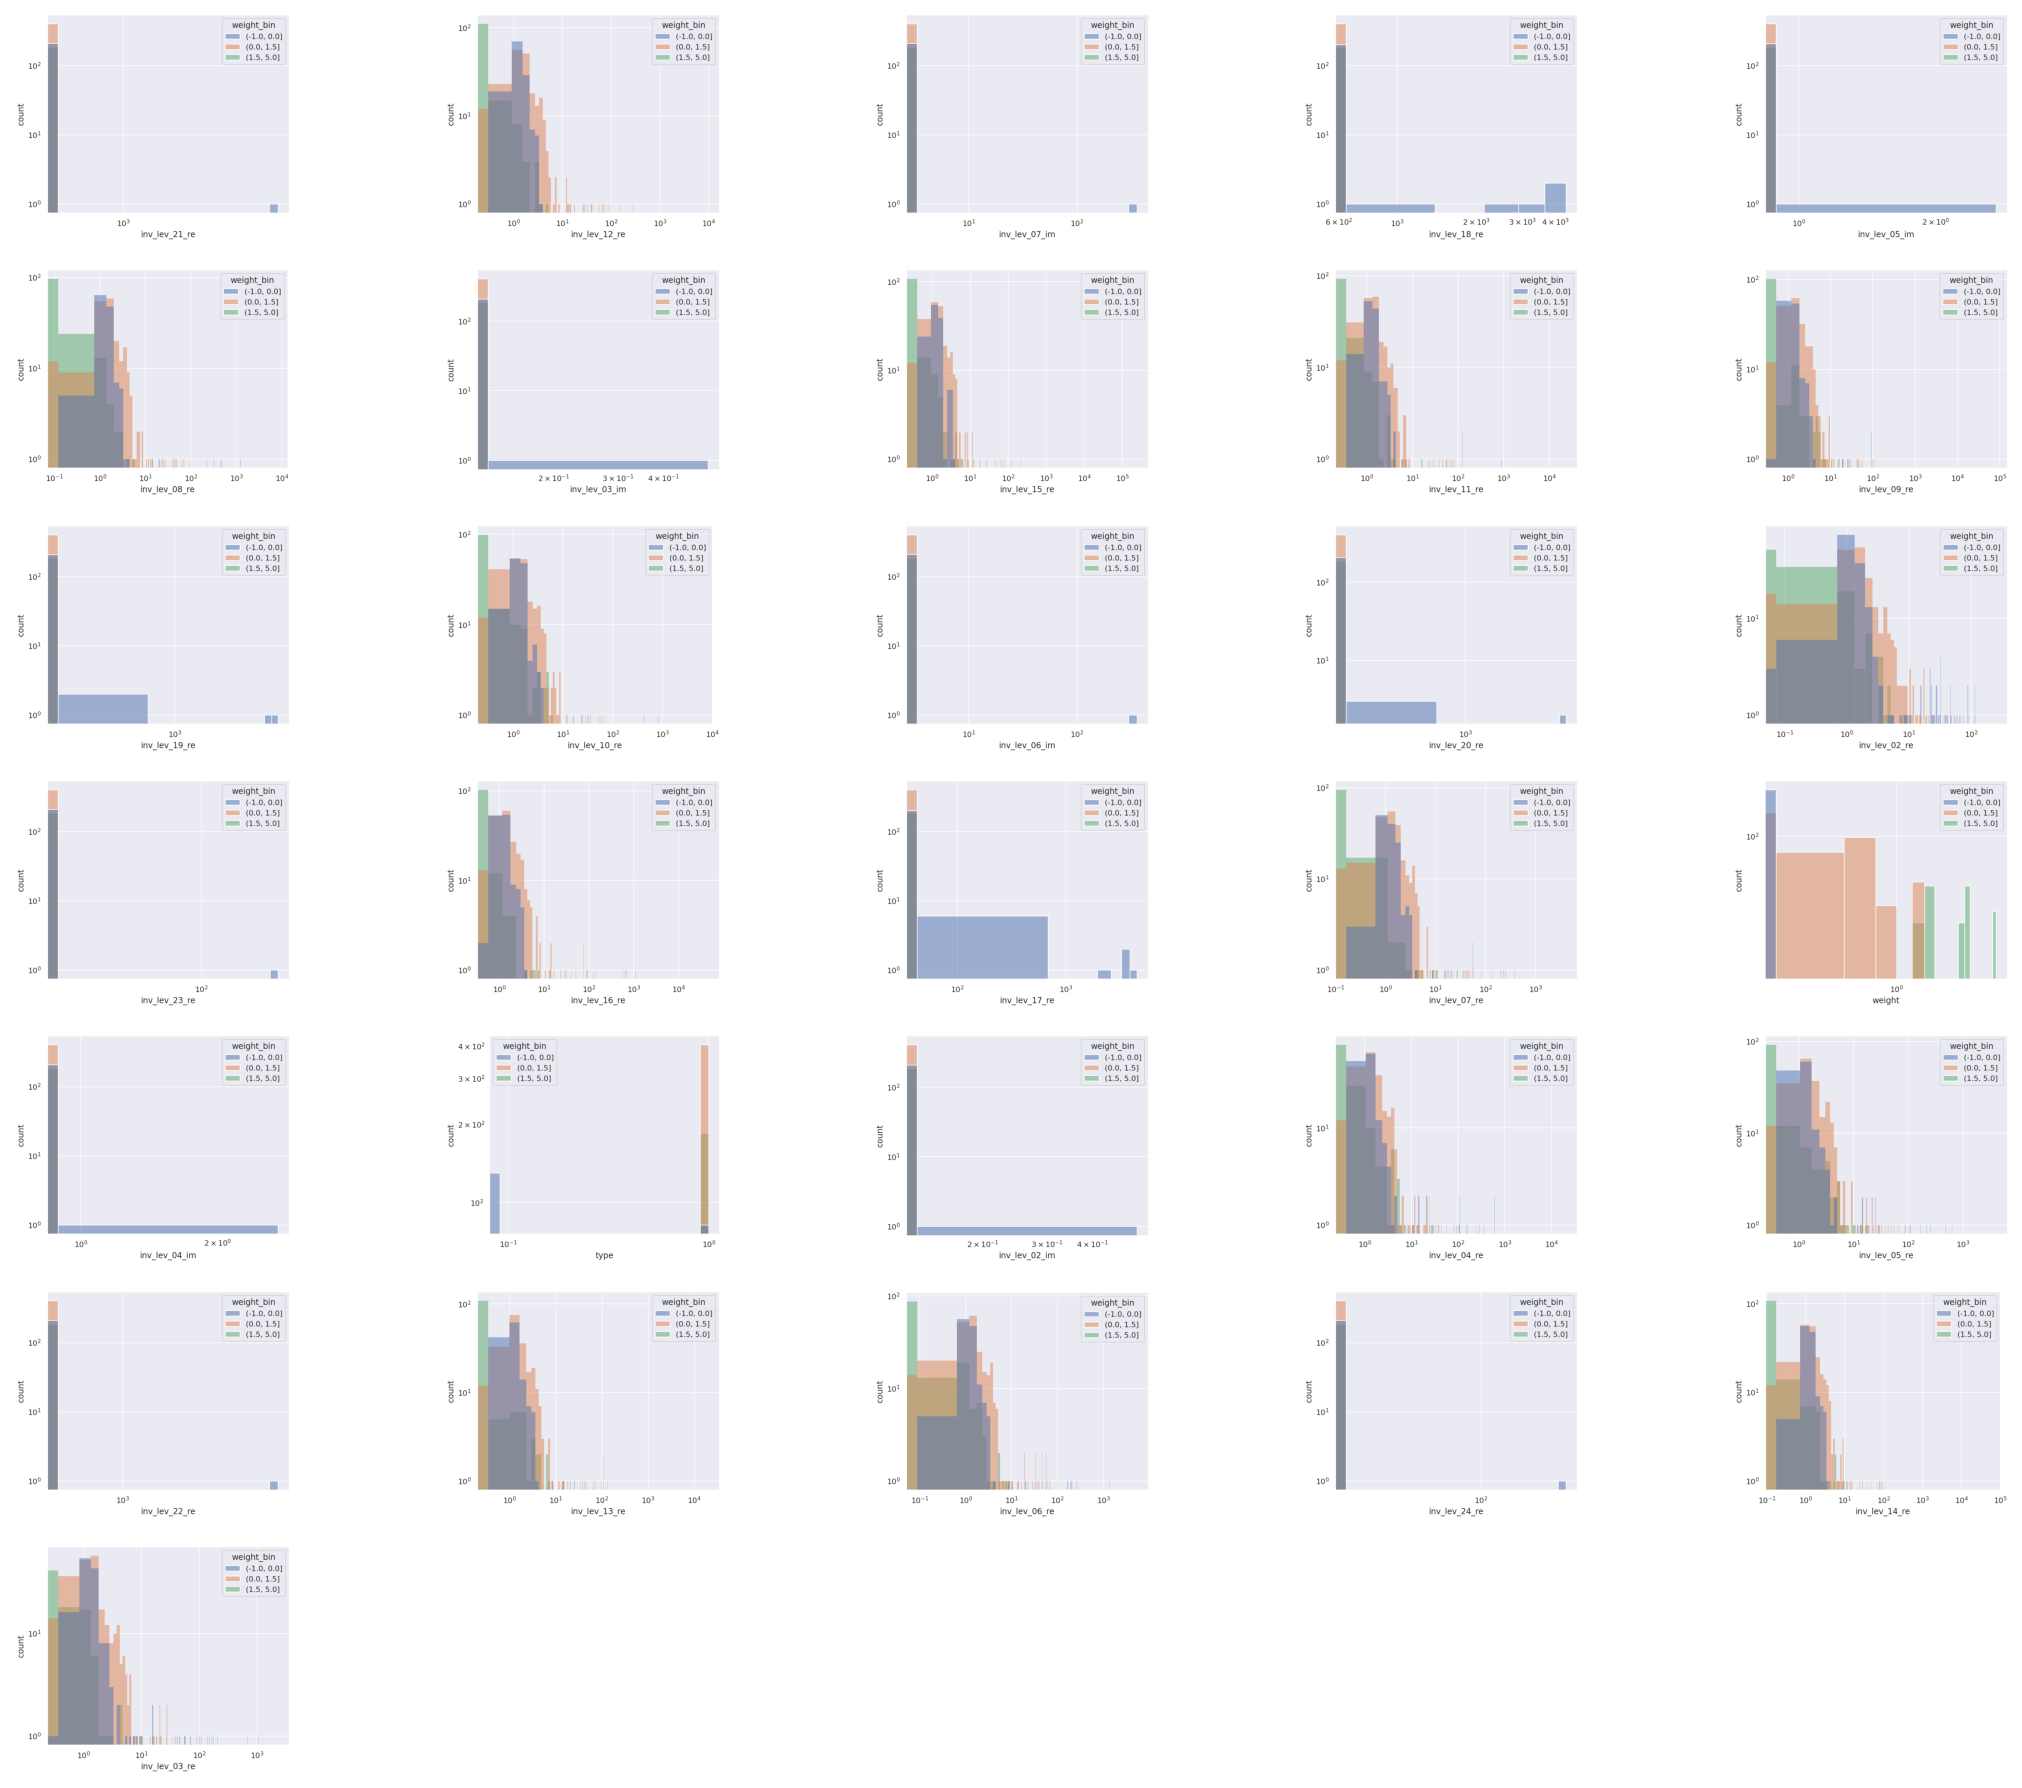

In [28]:
mosaic('./img/*_per_weight_bin_inv.png', 5, 5)

## Variable Ranking

We then use decision trees (boosted) to rank the truncation levels.
Specifically we proceed as follows:

1. we run the algorithm only for the native features,
2. we run the algorithm only for the inverse features (and compare with 1),
3. we run the algorithm for both kind of features.

The importance is measured using the type `split` in the *LGBMRegressor*, that is the number of times each feature is used to make a split.

At the moment the analysis is qualitative and does not require heavy optimisation.
We use 80% of the dataset for training, 10% for validation and 10% for testing.

In [29]:
# set random state
random_state = 123
np.random.seed(random_state)

In [30]:
# select 80% for the training set
train = df_full.sample(frac=0.8, random_state=random_state)
test  = df_full.loc[~df_full.index.isin(train.index)]

# select 10% for validation (50% of the test)
val   = test.sample(frac=0.5, random_state=random_state)
test  = test.loc[~test.index.isin(val.index)]

assert train.shape[0] + val.shape[0] + test.shape[0] == df_full.shape[0]

We then proceed with the ranking for the native features:

In [31]:
data_nat = {'X_train': train.filter(regex='^lev_*'),
            'y_train': train['exp'],
            'X_val':   val.filter(regex='^lev_*'),
            'y_val':   val['exp'],
            'X_test':  test.filter(regex='^lev_*'),
            'y_test':  test['exp']
           }

# create the regressor
nat_feat = LGBMRegressor(n_estimators=2000, num_leaves=20, learning_rate=0.03, importance_type='split', random_state=random_state)

# fit the regressor
nat_feat = nat_feat.fit(X=data_nat['X_train'], y=data_nat['y_train'], eval_set=(data_nat['X_val'], data_nat['y_val']), verbose=False)

# print stats
metric_nat = {'training':   np.mean(np.square(data_nat['y_train'].values - nat_feat.predict(data_nat['X_train']))),
              'validation': np.mean(np.square(data_nat['y_val'].values - nat_feat.predict(data_nat['X_val']))),
              'test':       np.mean(np.square(data_nat['y_test'].values - nat_feat.predict(data_nat['X_test'])))
             }
for key, value in metric_nat.items():
    print(f'MSE on the {key} set: {value:.3f}')

MSE on the training set: 0.022
MSE on the validation set: 0.093
MSE on the test set: 0.124


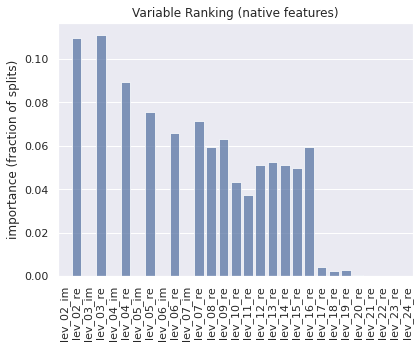

In [32]:
ranking_nat = {'features':   nat_feat.feature_name_,
               'importance': nat_feat.feature_importances_ / np.sum(nat_feat.feature_importances_)
              }

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=ratio(1,1))

sns.barplot(x='features',
            y='importance',
            data=ranking_nat,
            color='C0',
            alpha=0.75,
            ax=ax
           )
ax.set(title='Variable Ranking (native features)',
       ylabel='importance (fraction of splits)'
      )
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', va='top')
savefig('nat_feat_rank', fig, show=True)

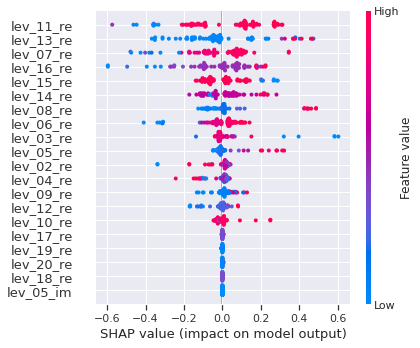

In [33]:
nat_explainer = shap.TreeExplainer(nat_feat)
nat_shap_val  = nat_explainer.shap_values(data_nat['X_test'])
shap.summary_plot(nat_shap_val, data_nat['X_test'], plot_size=ratio(1,1), show=False)
fig = plt.gcf()
savefig('nat_shap_values', fig, show=True)

The predictions seem therefore to be guided by the lowest order of the truncation levels (basically disregarding the imaginary parts).
The largest decision is then made by the central values.
The highest truncations seem to have no influence on the resulting prediction.

The we consider the inverse features:

In [34]:
data_inv = {'X_train': train.filter(regex='^inv_lev_*'),
            'y_train': train['exp'],
            'X_val':   val.filter(regex='^inv_lev_*'),
            'y_val':   val['exp'],
            'X_test':  test.filter(regex='^inv_lev_*'),
            'y_test':  test['exp']
           }

# create the regressor
inv_feat = LGBMRegressor(n_estimators=2000, num_leaves=20, learning_rate=0.03, importance_type='split', random_state=random_state)

# fit the regressor
inv_feat = inv_feat.fit(X=data_inv['X_train'], y=data_inv['y_train'], eval_set=(data_inv['X_val'], data_inv['y_val']), verbose=False)

# print stats
metric_inv = {'training':   np.mean(np.square(data_inv['y_train'].values - inv_feat.predict(data_nat['X_train']))),
              'validation': np.mean(np.square(data_inv['y_val'].values - inv_feat.predict(data_nat['X_val']))),
              'test':       np.mean(np.square(data_inv['y_test'].values - inv_feat.predict(data_nat['X_test'])))
             }
for key, value in metric_inv.items():
    print(f'MSE on the {key} set: {value:.3f}')

MSE on the training set: 0.693
MSE on the validation set: 0.687
MSE on the test set: 0.733


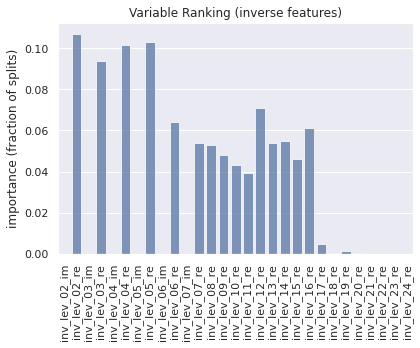

In [35]:
ranking_inv = {'features':   inv_feat.feature_name_,
               'importance': inv_feat.feature_importances_ / np.sum(inv_feat.feature_importances_)
              }

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=ratio(1,1))

sns.barplot(x='features',
            y='importance',
            data=ranking_inv,
            color='C0',
            alpha=0.75,
            ax=ax
           )
ax.set(title='Variable Ranking (inverse features)',
       ylabel='importance (fraction of splits)'
      )
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', va='top')
savefig('inv_feat_rank', fig, show=True)

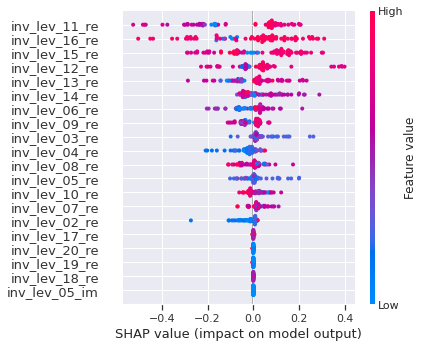

In [36]:
inv_explainer = shap.TreeExplainer(inv_feat)
inv_shap_val  = inv_explainer.shap_values(data_inv['X_test'])
shap.summary_plot(inv_shap_val, data_inv['X_test'], plot_size=ratio(1,1), show=False)
fig = plt.gcf()
savefig('inv_shap_values', fig, show=True)

Even for the inverse features the analysis holds.
The initial decision is made by the lowest orders of truncation (leaving the imaginary parts aside) and finally led by the central truncations.
The highest orders can be discarded.

We then consider the full spectrum of features to compare them:

In [37]:
data_full = {'X_train': train.filter(regex='^lev_*|^inv_lev_*'),
             'y_train': train['exp'],
             'X_val':   val.filter(regex='^lev_*|^inv_lev_*'),
             'y_val':   val['exp'],
             'X_test':  test.filter(regex='^lev_*|^inv_lev_*'),
             'y_test':  test['exp']
            }

# create the regressor
full_feat = LGBMRegressor(n_estimators=2000, num_leaves=20, learning_rate=0.03, importance_type='split', random_state=random_state)

# fit the regressor
full_feat = inv_feat.fit(X=data_full['X_train'], y=data_full['y_train'], eval_set=(data_full['X_val'], data_full['y_val']), verbose=False)

# print stats
metric_full = {'training':   np.mean(np.square(data_full['y_train'].values - inv_feat.predict(data_full['X_train']))),
               'validation': np.mean(np.square(data_full['y_val'].values - inv_feat.predict(data_full['X_val']))),
               'test':       np.mean(np.square(data_full['y_test'].values - inv_feat.predict(data_full['X_test'])))
              }
for key, value in metric_full.items():
    print(f'MSE on the {key} set: {value:.3f}')

MSE on the training set: 0.002
MSE on the validation set: 0.084
MSE on the test set: 0.128


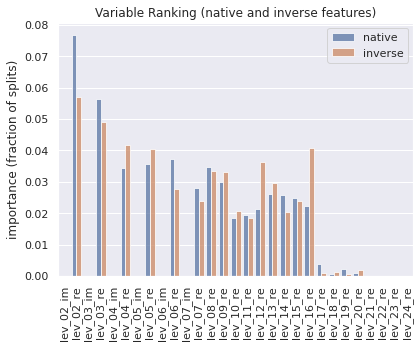

In [38]:
ranking_full = {'features':   [re.sub('^inv_', '', feat) for feat in full_feat.feature_name_],
                'importance': full_feat.feature_importances_ / np.sum(full_feat.feature_importances_),
                'type':       ['native' if re.match('^lev_*', feat) else 'inverse' for feat in full_feat.feature_name_]
               }

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=ratio(1,1))

sns.barplot(x='features',
            y='importance',
            hue='type',
            data=ranking_full,
            palette=sns.color_palette(n_colors=2),
            alpha=0.75,
            ax=ax
           )
ax.set(title='Variable Ranking (native and inverse features)',
       ylabel='importance (fraction of splits)'
      )
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', va='top')
savefig('full_feat_rank', fig, show=True)

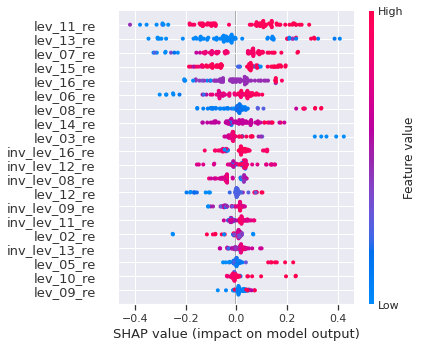

In [39]:
full_explainer = shap.TreeExplainer(full_feat)
full_shap_val  = full_explainer.shap_values(data_full['X_test'])
shap.summary_plot(full_shap_val, data_full['X_test'], plot_size=ratio(1,1), show=False)
fig = plt.gcf()
savefig('inv_shap_values', fig, show=True)

Keeping all features (native and inverse) seems to be beneficial for the model as both kind of engineered features are equally important to the model.
We can finally remove the imaginary parts and truncation levels above `lev_17`.

## Baseline

As a last step we finally fit a simple linear model to the native and the inverse features to establish the importance of each feature using an unregularised linear regressor (we do not fit the intercept).

In [40]:
nat_feat_col  = 'exp ~ weight + C(type) + ' + ' + '.join([feat for feat in train.columns if re.match('^lev_*', feat)]) + ' - 1'
inv_feat_col  = 'exp ~ weight + C(type) + ' + ' + '.join([feat for feat in train.columns if re.match('^inv_lev_*', feat)]) + ' - 1'
full_feat_col = 'exp ~ weight + C(type) + ' + ' + '.join([feat for feat in train.columns if re.match('^lev_*|^inv_lev_*', feat)]) + ' - 1'

MSE on the training set: 0.019
MSE on the test set: 0.027
                               Native Features                                
Dep. Variable:                    exp   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     470.4
Date:                Tue, 24 Nov 2020   Prob (F-statistic):               0.00
Time:                        02:22:30   Log-Likelihood:                 358.21
No. Observations:                 642   AIC:                            -658.4
Df Residuals:                     613   BIC:                            -529.0
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

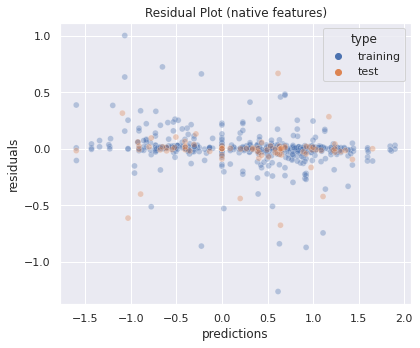

In [41]:
# native features
nat_feat_lm  = smf.ols(nat_feat_col, data=train).fit()
nat_feat_sum = nat_feat_lm.summary(title='Native Features')

# predictions
nat_preds = {'train': nat_feat_lm.predict(train.filter(regex='weight|type|^lev_*')),
             'test':  nat_feat_lm.predict(test.filter(regex='weight|type|^lev_*'))
            }

# metrics
nat_metrics = {'training':   np.mean(np.square(nat_preds['train'] - train['exp'])),
               'test':       np.mean(np.square(nat_preds['test'] - test['exp']))
              }
for key, value in nat_metrics.items():
    print(f'MSE on the {key} set: {value:.3f}')
    
print(nat_feat_sum)

# plot the residual plot
nat_residuals = {'residuals':   list(nat_preds['train'] - train['exp']) + list(nat_preds['test'] - test['exp']),
                 'type':        ['training'] * len(list(nat_preds['train'] - train['exp'])) + ['test'] * len(list(nat_preds['test'] - test['exp'])),
                 'predictions': list(train['exp']) + list(test['exp'])
                }
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=ratio(1,1))

sns.scatterplot(x='predictions',
                y='residuals',
                hue='type',
                data=nat_residuals,
                alpha=0.35,
                ax=ax
               )
ax.set_title('Residual Plot (native features)')
savefig('nat_feat_res_plot', fig, show=True)

In [42]:
# check that on average the residuals sum to 0
print(f'Sum of the residuals: {np.sum(nat_feat_lm.resid)}\n')

# check the heteroscedasticity of the model
nat_feat_resfit = sm.OLS(nat_feat_lm.resid, sm.add_constant(train['exp'])).fit()
print(nat_feat_resfit.summary(title='Fit of the residuals (heteroscedasticity check)'))

Sum of the residuals: -2.0657031640780588e-11

               Fit of the residuals (heteroscedasticity check)                
Dep. Variable:                      y   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     29.79
Date:                Tue, 24 Nov 2020   Prob (F-statistic):           6.90e-08
Time:                        02:22:31   Log-Likelihood:                 372.82
No. Observations:                 642   AIC:                            -741.6
Df Residuals:                     640   BIC:                            -732.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const

We notice the native features are well explained by a linear models in the coefficients.
In fact we can just retain the real part of the truncation level and actually focus only on them (the `weight` and `type` do not seem to influence the behaviour).
The residuals seem to have a slight dependence on the dependent variable but the correlation is almost non existent.
They correctly sum to zero on average.

We then look at the inverse features:

MSE on the training set: 0.417
MSE on the test set: 0.503
                               Inverse Features                               
Dep. Variable:                    exp   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.7335
Date:                Tue, 24 Nov 2020   Prob (F-statistic):              0.841
Time:                        02:22:31   Log-Likelihood:                -630.44
No. Observations:                 642   AIC:                             1319.
Df Residuals:                     613   BIC:                             1448.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

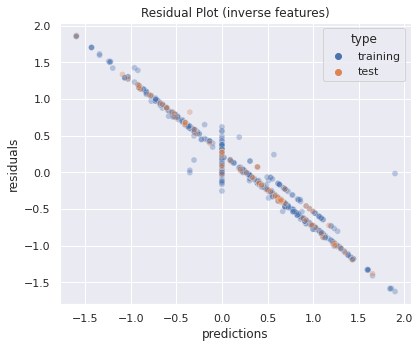

In [43]:
# inverse features
inv_feat_lm  = smf.ols(inv_feat_col, data=train).fit()
inv_feat_sum = inv_feat_lm.summary(title='Inverse Features')

# predictions
inv_preds = {'train': inv_feat_lm.predict(train.filter(regex='weight|type|^inv_lev_*')),
             'test':  inv_feat_lm.predict(test.filter(regex='weight|type|^inv_lev_*'))
            }

# metrics
inv_metrics = {'training':   np.mean(np.square(inv_preds['train'] - train['exp'])),
               'test':       np.mean(np.square(inv_preds['test'] - test['exp']))
              }
for key, value in inv_metrics.items():
    print(f'MSE on the {key} set: {value:.3f}')
    
print(inv_feat_sum)

# plot the residual plot
inv_residuals = {'residuals':   list(inv_preds['train'] - train['exp']) + list(inv_preds['test'] - test['exp']),
                 'type':        ['training'] * len(list(inv_preds['train'] - train['exp'])) + ['test'] * len(list(inv_preds['test'] - test['exp'])),
                 'predictions': list(train['exp']) + list(test['exp'])
                }
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=ratio(1,1))

sns.scatterplot(x='predictions',
                y='residuals',
                hue='type',
                data=inv_residuals,
                alpha=0.35,
                ax=ax
               )
ax.set_title('Residual Plot (inverse features)')
savefig('inv_feat_res_plot', fig, show=True)

In [44]:
# check that on average the residuals sum to 0
print(f'Sum of the residuals: {np.sum(inv_feat_lm.resid)}\n')

# check the heteroscedasticity of the model
inv_feat_resfit = sm.OLS(inv_feat_lm.resid, sm.add_constant(train['exp'])).fit()
print(inv_feat_resfit.summary(title='Fit of the residuals (heteroscedasticity check)'))

Sum of the residuals: 3.297841999483353e-10

               Fit of the residuals (heteroscedasticity check)                
Dep. Variable:                      y   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                 1.910e+04
Date:                Tue, 24 Nov 2020   Prob (F-statistic):               0.00
Time:                        02:22:32   Log-Likelihood:                 470.27
No. Observations:                 642   AIC:                            -936.5
Df Residuals:                     640   BIC:                            -927.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const  

A linear model is definitely incomplete and cannot explain the inverse features.
In fact they present a case of very high heteroscedasticity (as shown by the correlation of the fit of the residuals, proved also by a high depedence of the dependent variable).
On average the residuals do not fully add up to zero, even though the sum approaches the vanishing result.
They might however be used in combination with the native features for predictions.

MSE on the training set: 0.019
MSE on the test set: 0.026
                         Native and Inverse Features                          
Dep. Variable:                    exp   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     254.1
Date:                Tue, 24 Nov 2020   Prob (F-statistic):               0.00
Time:                        02:22:32   Log-Likelihood:                 358.41
No. Observations:                 642   AIC:                            -614.8
Df Residuals:                     591   BIC:                            -387.1
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

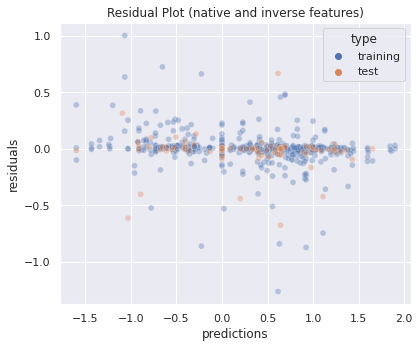

In [45]:
# native and inverse features
full_feat_lm  = smf.ols(full_feat_col, data=train).fit()
full_feat_sum = full_feat_lm.summary(title='Native and Inverse Features')

# predictions
full_preds = {'train': full_feat_lm.predict(train.filter(regex='weight|type|^lev_*|^inv_lev_*')),
              'test':  full_feat_lm.predict(test.filter(regex='weight|type|^lev_*|^inv_lev_*'))
             }

# metrics
full_metrics = {'training':   np.mean(np.square(full_preds['train'] - train['exp'])),
                'test':       np.mean(np.square(full_preds['test'] - test['exp']))
                }
for key, value in full_metrics.items():
    print(f'MSE on the {key} set: {value:.3f}')
    
print(full_feat_sum)

# plot the residual plot
full_residuals = {'residuals':   list(full_preds['train'] - train['exp']) + list(full_preds['test'] - test['exp']),
                  'type':        ['training'] * len(list(full_preds['train'] - train['exp'])) + ['test'] * len(list(full_preds['test'] - test['exp'])),
                  'predictions': list(train['exp']) + list(test['exp'])
                 }
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=ratio(1,1))

sns.scatterplot(x='predictions',
                y='residuals',
                hue='type',
                data=full_residuals,
                alpha=0.35,
                ax=ax
               )
ax.set_title('Residual Plot (native and inverse features)')
savefig('full_feat_res_plot', fig, show=True)

In [46]:
# check that on average the residuals sum to 0
print(f'Sum of the residuals: {np.sum(full_feat_lm.resid)}\n')

# check the heteroscedasticity of the model
full_feat_resfit = sm.OLS(full_feat_lm.resid, sm.add_constant(train['exp'])).fit()
print(full_feat_resfit.summary(title='Fit of the residuals (heteroscedasticity check)'))

Sum of the residuals: -2.2969537383232819e-10

               Fit of the residuals (heteroscedasticity check)                
Dep. Variable:                      y   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     29.77
Date:                Tue, 24 Nov 2020   Prob (F-statistic):           6.97e-08
Time:                        02:22:33   Log-Likelihood:                 373.01
No. Observations:                 642   AIC:                            -742.0
Df Residuals:                     640   BIC:                            -733.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const

Residuals approach the vanishing sum of average, though the result is higher than machine precision.
There is still a slight dependence of the residuals on the dependent variable, though the correlation of the coefficient is almost zero.
In general the combination of the native and the inverse features seem to improve the general result.

To discriminate between the models we use the ANOVA between the three models to see whether adding the inverse features is actually useful:

In [47]:
anova_lm(nat_feat_lm, full_feat_lm)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,613.0,12.314586,0.0,NaN,NaN,NaN
1,591.0,12.306906,22.0,0.007679,0.016763,1.0


In [48]:
anova_lm(inv_feat_lm, full_feat_lm)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,613.0,267.919235,0.0,NaN,NaN,NaN
1,591.0,12.306906,22.0,255.612329,557.953114,0.0


From the ANOVA it seems that adding the inverse features does not help the model at all. In fact the inverse is actually a good move: from the inverse features it is necessary to the native features to improve the model.

We then quickly check the possible interaction term between the `type` and the `weight` variables.
We build a simple models made of only those variables and their interaction term for comparison.

In [49]:
interaction_lm = smf.ols('exp ~ C(type) * weight - 1', data=train).fit()
print(interaction_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    exp   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.5646
Date:                Tue, 24 Nov 2020   Prob (F-statistic):              0.569
Time:                        02:22:34   Log-Likelihood:                -640.45
No. Observations:                 642   AIC:                             1287.
Df Residuals:                     639   BIC:                             1300.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
C(type)[0]              0.3283    

It seems that nor the interaction between `type` and `weight` nor the isolated coefficients actually have an impact on the model.

We finally consider just the native features and fit a model using interaction terms between the `type` and the `weight` variables and the truncation levels.

In [50]:
interactions = 'exp ~ weight + C(type) + ' \
             + ' + '.join([feat for feat in train.columns if re.match('^lev_*', feat)]) \
             + ' + ' + ' + '.join(['weight * ' + feat for feat in train.columns if re.match('^lev_*', feat)]) \
             + ' + ' + ' + '.join(['C(type) * ' + feat for feat in train.columns if re.match('^lev_*', feat)]) \
             + ' - 1'

In [51]:
interactions_lm = smf.ols(interactions, data=train).fit()
print(interactions_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    exp   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     790.5
Date:                Tue, 24 Nov 2020   Prob (F-statistic):               0.00
Time:                        02:22:34   Log-Likelihood:                 835.51
No. Observations:                 642   AIC:                            -1527.
Df Residuals:                     570   BIC:                            -1206.
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
C(type)[0]             -7.16

While the interaction between the `type` variable and the other variables does not seem to introduce beneficial effects, it could be that the introduction of an interaction term with the `weight` is good for the model.
We therefore try another linear model with just an interaction term between the `weight` and the truncation levels.

In [52]:
refined_interactions = 'exp ~ weight + C(type) + ' \
                     + ' + '.join([feat for feat in train.columns if re.match('^lev_*', feat)]) \
                     + ' + ' + ' + '.join(['weight * ' + feat for feat in train.columns if re.match('^lev_*', feat)]) \
                     + ' - 1'

In [53]:
refined_interactions_lm = smf.ols(refined_interactions, data=train).fit()
print(refined_interactions_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    exp   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     1113.
Date:                Tue, 24 Nov 2020   Prob (F-statistic):               0.00
Time:                        02:22:35   Log-Likelihood:                 821.32
No. Observations:                 642   AIC:                            -1541.
Df Residuals:                     591   BIC:                            -1313.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
C(type)[0]           0.0041      0.007  

We then perform the ANOVA between various models to see which linear regression is best:

In [54]:
anova_lm(nat_feat_lm, interactions_lm)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,613.0,12.314586,0.0,NaN,NaN,NaN
1,570.0,2.783981,43.0,9.530605,45.3796,1.973775e-155


In [55]:
anova_lm(nat_feat_lm, refined_interactions_lm)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,613.0,12.314586,0.0,NaN,NaN,NaN
1,591.0,2.909831,22.0,9.404754,86.824923,8.192691e-169


Since the addition of the interaction term is an improvement, we may conclude that with its addition not only does the resulting model improve but it is also different than before.
In fact we show the scatter plot of the residuals of this last model.

MSE on the training set: 0.005
MSE on the test set: 0.014


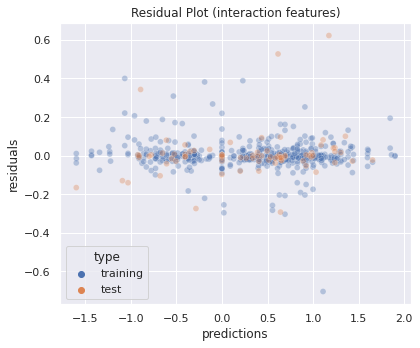

In [56]:
# predictions
int_preds = {'train': refined_interactions_lm.predict(train.filter(regex='weight|type|^lev_*')),
             'test':  refined_interactions_lm.predict(test.filter(regex='weight|type|^lev_*'))
            }

# metrics
int_metrics = {'training':   np.mean(np.square(int_preds['train'] - train['exp'])),
               'test':       np.mean(np.square(int_preds['test'] - test['exp']))
               }
for key, value in int_metrics.items():
    print(f'MSE on the {key} set: {value:.3f}')

# plot the residual plot
int_residuals = {'residuals':   list(int_preds['train'] - train['exp']) + list(int_preds['test'] - test['exp']),
                 'type':        ['training'] * len(list(int_preds['train'] - train['exp'])) + ['test'] * len(list(int_preds['test'] - test['exp'])),
                 'predictions': list(train['exp']) + list(test['exp'])
                }
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=ratio(1,1))

sns.scatterplot(x='predictions',
                y='residuals',
                hue='type',
                data=int_residuals,
                alpha=0.35,
                ax=ax
               )
ax.set_title('Residual Plot (interaction features)')
savefig('interactions_res_plot', fig, show=True)

In [57]:
# check that on average the residuals sum to 0
print(f'Sum of the residuals: {np.sum(refined_interactions_lm.resid)}\n')

# check the heteroscedasticity of the model
refined_interactions_resfit = sm.OLS(refined_interactions_lm.resid, sm.add_constant(train['exp'])).fit()
print(refined_interactions_resfit.summary(title='Fit of the residuals (heteroscedasticity check)'))

Sum of the residuals: 1.8472842810979273e-08

               Fit of the residuals (heteroscedasticity check)                
Dep. Variable:                      y   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     6.797
Date:                Tue, 24 Nov 2020   Prob (F-statistic):            0.00934
Time:                        02:22:36   Log-Likelihood:                 824.71
No. Observations:                 642   AIC:                            -1645.
Df Residuals:                     640   BIC:                            -1636.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

The residuals seem to be slightly correlated between them, even though the confidence intervals of the dependent variable are more compatible with the vanishing result.

## Feature Selection

In this last part we finally select the features which analysis showed to be better to build a model.
Specifically we proceed as follows:

1. select only the real part of the truncation levels (native features only),
2. discard any level above `lev_16`,
3. add the interaction between `weight` and the truncation levels,
4. drop the original `weight` column.

We then perform the last baseline using a linear model.

In [58]:
# select only real parts of the native features
df_ref = df_full.filter(regex='solution|observable|weight|type|^lev.*_re$')

# discard anything above level 16 (remember to keep the label)
df_ref        = df_ref.loc[:, 'solution':'lev_16_re']
df_ref['exp'] = df_full['exp']
df_ref        = df_ref.rename(columns=lambda c: re.sub('_re', '', c))

# add interactions
int_cols = df_ref.loc[:, 'lev_02':'lev_16'].columns
for c in int_cols:
    df_ref[c + '_x_weight'] = df_ref[c] * df_ref['weight']
    
# discard weight and type
df_ref = df_ref.drop(columns=['weight'])

In [59]:
# select columns and prepare the formula
cols_list = sorted(list(df_ref.columns)[2:])
cols_list = [re.sub('type', 'C(type)', c) for c in cols_list]
indep_var = cols_list[1:]
dep_var   = cols_list[0]
formula   = dep_var + ' ~ ' + ' + '.join(indep_var) + ' - 1'

# perform the linear fit
df_ref_lm = smf.ols(formula, data=df_ref).fit()
print(df_ref_lm.summary(title='Refined Model'))

                                Refined Model                                 
Dep. Variable:                    exp   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     1537.
Date:                Tue, 24 Nov 2020   Prob (F-statistic):               0.00
Time:                        02:22:37   Log-Likelihood:                 860.89
No. Observations:                 802   AIC:                            -1658.
Df Residuals:                     770   BIC:                            -1508.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
C(type)[0]          0.0033      0.008     

The performance of the model can then be assessed using the mean squared error and the residual plot.

MSE of the model: 0.007


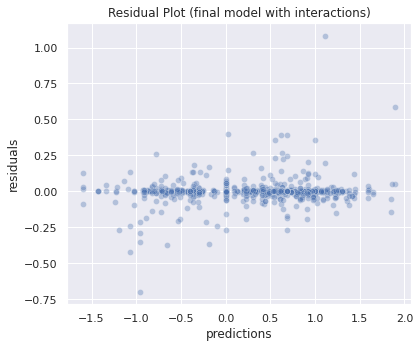

In [60]:
# print the mean squared error
mse = np.mean(np.square(df_ref_lm.resid))
print(f'MSE of the model: {mse:.3f}')

# print the residual plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=ratio(1,1))

sns.scatterplot(x=df_ref['exp'],
                y=df_ref_lm.resid,
                alpha=0.35,
                ax=ax
               )
ax.set(title='Residual Plot (final model with interactions)',
       xlabel='predictions',
       ylabel='residuals'
      )
savefig('final_model_res_plot', fig, show=True)

In [61]:
# check that on average the residuals sum to 0
print(f'Sum of the residuals: {np.sum(df_ref_lm.resid)}\n')

# check the heteroscedasticity of the model
df_ref_resfit = sm.OLS(df_ref_lm.resid, sm.add_constant(df_ref['exp'])).fit()
print(df_ref_resfit.summary(title='Fit of the residuals (heteroscedasticity check)'))

Sum of the residuals: 3.5927705255289766e-11

               Fit of the residuals (heteroscedasticity check)                
Dep. Variable:                      y   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     12.93
Date:                Tue, 24 Nov 2020   Prob (F-statistic):           0.000344
Time:                        02:22:37   Log-Likelihood:                 867.32
No. Observations:                 802   AIC:                            -1731.
Df Residuals:                     800   BIC:                            -1721.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

The model presents homoscedasticity (the residuals are homogeneous in their distribution since they are not correlated).
We will therefore use the last dataset for the machine learning procedure.

## Save the Dataset

We save the dataset in JSON and CSV format for future use.

In [62]:
df_ref = df_ref[list(df_ref.drop(columns=['exp']).columns) + ['exp']]

In [63]:
df_ref.to_json('./data/data_ml.json.gz', orient='records')